## Libraries

In [1]:
import sys
import os
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Loading Models

In [ ]:
import math
import torch
import torch.nn as nn
import timm

class HRNetSeg(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.backbone = timm.create_model(
            "hrnet_w32",
            pretrained=True,
            features_only=True
        )

        # HRNet outputs: [C1, C2, C3, C4] multi-scale features
        # Use the highest-resolution branch (index 0)
        in_ch = self.backbone.feature_info.channels()[0]

        self.seg_head = nn.Sequential(
            nn.Conv2d(in_ch, 256, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, num_classes, 1)
        )

    def forward(self, x):
        feats = self.backbone(x)[0]   # pick highest resolution feature
        return self.seg_head(feats)

def load_hrnet_model(checkpoint_path=None):
    model = HRNetSeg(num_classes=3)
    
    if checkpoint_path:
        print(f"Loading HRNet Fine-tuned from {checkpoint_path}...")
        state_dict = torch.load(checkpoint_path, map_location='cpu')
        if list(state_dict.keys())[0].startswith('module.'):
            state_dict = {k[7:]: v for k, v in state_dict.items()}
        missing, unexpected = model.load_state_dict(state_dict, strict=False)
        print(f"Weights Loaded. Missing keys: {len(missing)}, Unexpected keys: {len(unexpected)}")
        if len(missing) > 0: print(f"WARNING: Missing keys (Head might be random): {missing[:5]}")
    else:
        print("Loading HRNet Base (ImageNet Backbone)...")
    
    model.to(device)
    model.eval()
    return model

HRNET_CKPT_PATH = "/kaggle/input/hrnet-checkpoint-on-viton-hd/hrnet_finetuned.pth" 

print("Loading Models")
hrnet_base = load_hrnet_model(checkpoint_path=None)

hrnet_ft = load_hrnet_model(HRNET_CKPT_PATH)

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Loading Models


model.safetensors:   0%|          | 0.00/165M [00:00<?, ?B/s]

Unexpected keys (downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.num_batches_tracked, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.num_batches_tracked, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.num_batches_tracked, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Loading HRNet Base (ImageNet Backbone)...


Unexpected keys (downsamp_modules.0.0.bias, downsamp_modules.0.0.weight, downsamp_modules.0.1.bias, downsamp_modules.0.1.num_batches_tracked, downsamp_modules.0.1.running_mean, downsamp_modules.0.1.running_var, downsamp_modules.0.1.weight, downsamp_modules.1.0.bias, downsamp_modules.1.0.weight, downsamp_modules.1.1.bias, downsamp_modules.1.1.num_batches_tracked, downsamp_modules.1.1.running_mean, downsamp_modules.1.1.running_var, downsamp_modules.1.1.weight, downsamp_modules.2.0.bias, downsamp_modules.2.0.weight, downsamp_modules.2.1.bias, downsamp_modules.2.1.num_batches_tracked, downsamp_modules.2.1.running_mean, downsamp_modules.2.1.running_var, downsamp_modules.2.1.weight, final_layer.0.bias, final_layer.0.weight, final_layer.1.bias, final_layer.1.num_batches_tracked, final_layer.1.running_mean, final_layer.1.running_var, final_layer.1.weight, classifier.bias, classifier.weight) found while loading pretrained weights. This may be expected if model is being adapted.


Loading HRNet Fine-tuned from /kaggle/input/hrnet-checkpoint-on-viton-hd/hrnet_finetuned.pth...
Weights Loaded. Missing keys: 0, Unexpected keys: 0


## Dataset

In [ ]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

ROOT_DIR = "/kaggle/input/high-resolution-viton-zalando-dataset"
MASK_DIR = os.path.join(ROOT_DIR, 'test', 'image-parse-v3')
if not os.path.exists(MASK_DIR):
    MASK_DIR = os.path.join(ROOT_DIR, 'test', 'image-parse')

class VITONEvalDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.image_dir = os.path.join(root_dir, 'test', 'image')
        self.mask_dir = os.path.join(root_dir, 'test', 'image-parse-v3')
        
        self.images = sorted([f for f in os.listdir(self.image_dir) if f.endswith(('.jpg', '.png'))])
        
        self.eval_size = (512, 384) 
        self.img_transform = transforms.Compose([
            transforms.Resize(self.eval_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        
        base = os.path.splitext(img_name)[0]
        mask_path = None
        for ext in ['.png', '.jpg', '_label.png']:
            p = os.path.join(self.mask_dir, base + ext)
            if os.path.exists(p):
                mask_path = p; break
        
        img_pil = Image.open(img_path).convert("RGB")
        original_size = img_pil.size[::-1] # (H, W)
        
        if mask_path:
            mask_pil = Image.open(mask_path)
            mask_np = np.array(mask_pil)
            # Map Labels: 5,6,7 -> 1 (Upper), Others -> 0 or 2
            gt_mask = np.zeros_like(mask_np)
            # Upper Clothes
            for l in [5, 6, 7]: gt_mask[mask_np == l] = 1
            # Body/Skin
            for l in [10, 11, 13, 14, 15]: gt_mask[mask_np == l] = 2
        else:
            gt_mask = np.zeros(original_size, dtype=np.uint8)

        input_tensor = self.img_transform(img_pil)

        return {
            "tensor": input_tensor,
            "original_img": np.array(img_pil), # For viz
            "gt_mask": gt_mask,
            "name": img_name
        }

dataset = VITONEvalDataset(ROOT_DIR)
dataloader = DataLoader(dataset, batch_size=4, shuffle=False)
print("Test images: ", len(dataset))

Test images:  2032


## Evaluation

Starting Evaluation (Upper Clothes Only)...


  0%|          | 0/508 [00:00<?, ?it/s]

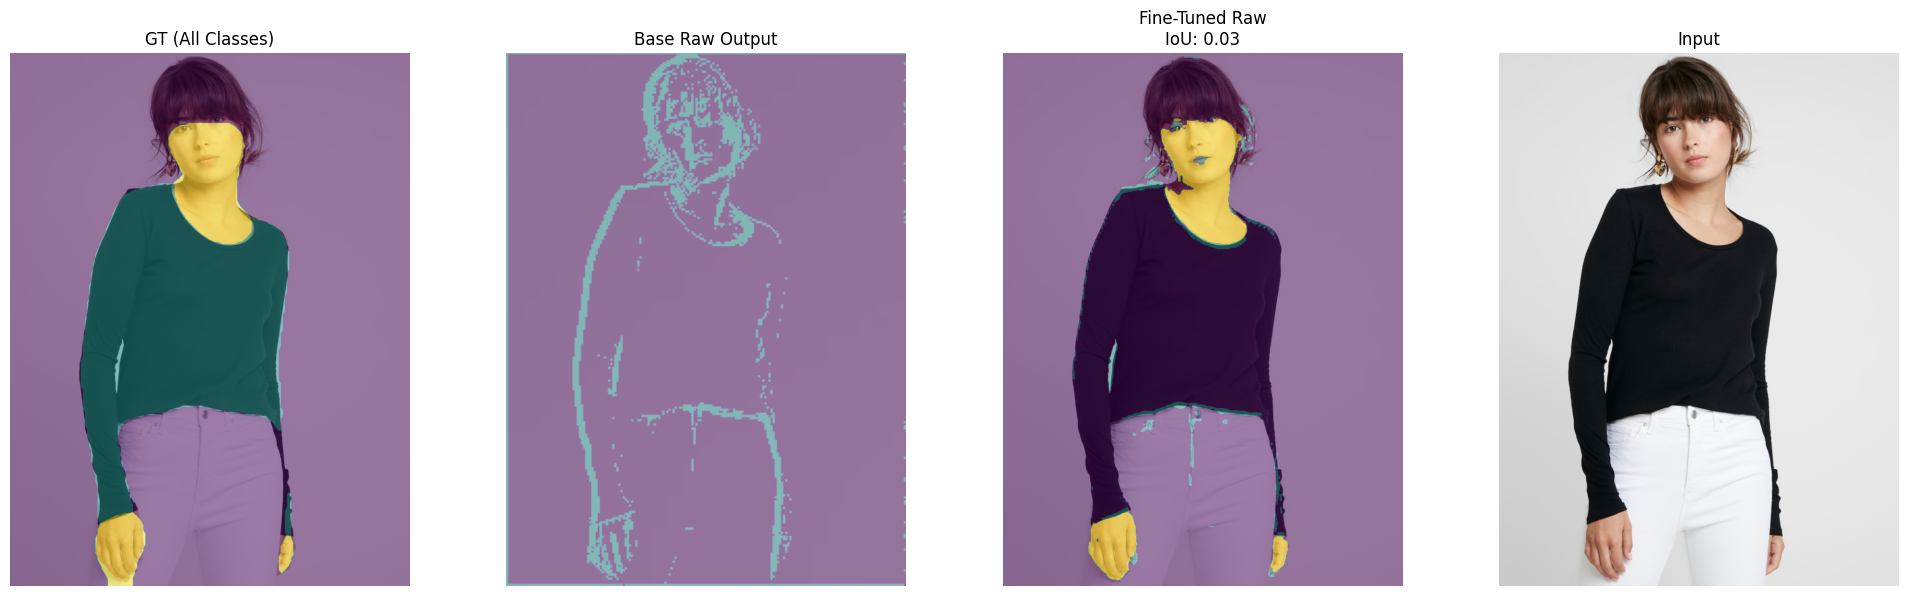

  0%|          | 1/508 [00:02<18:24,  2.18s/it]

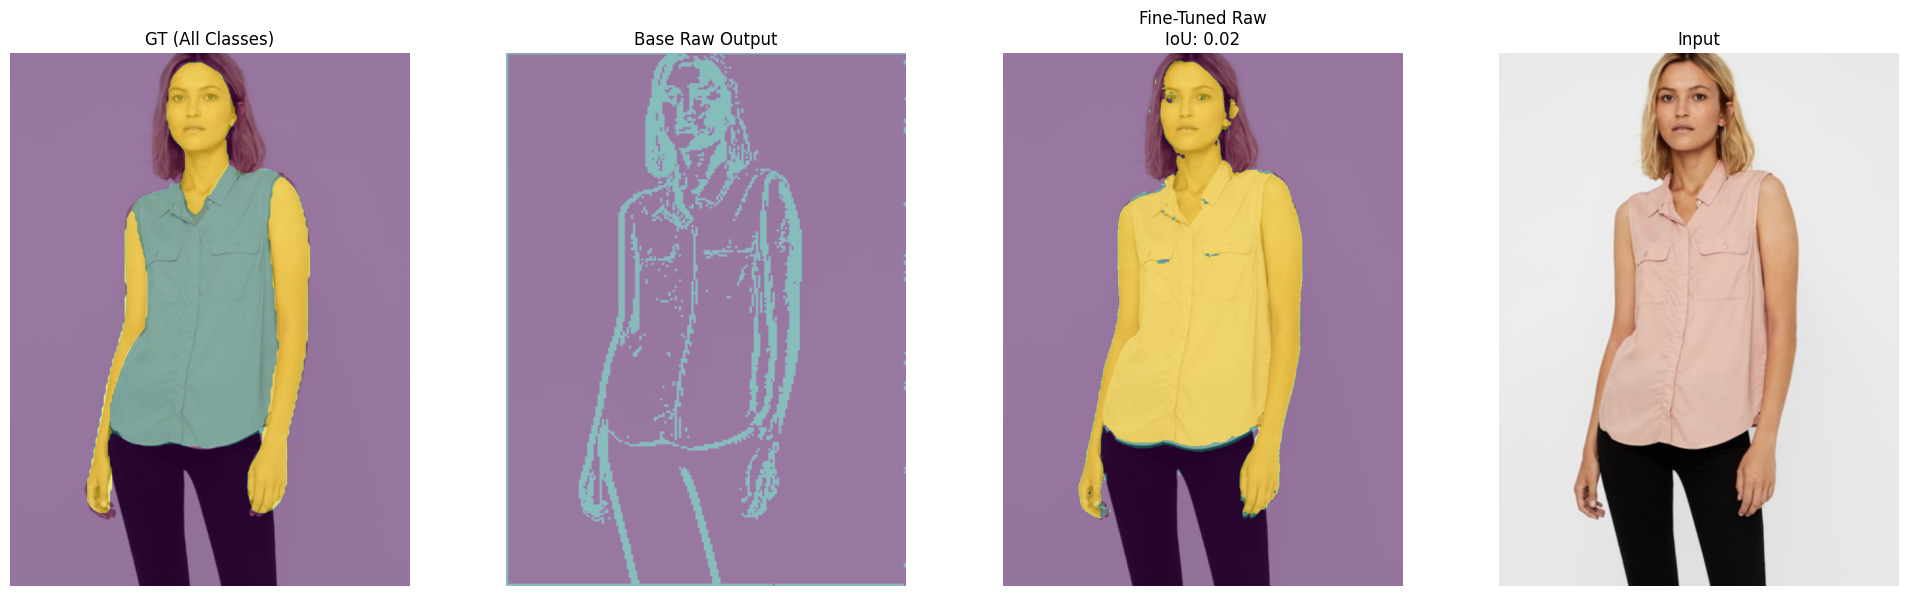

  0%|          | 2/508 [00:03<14:18,  1.70s/it]

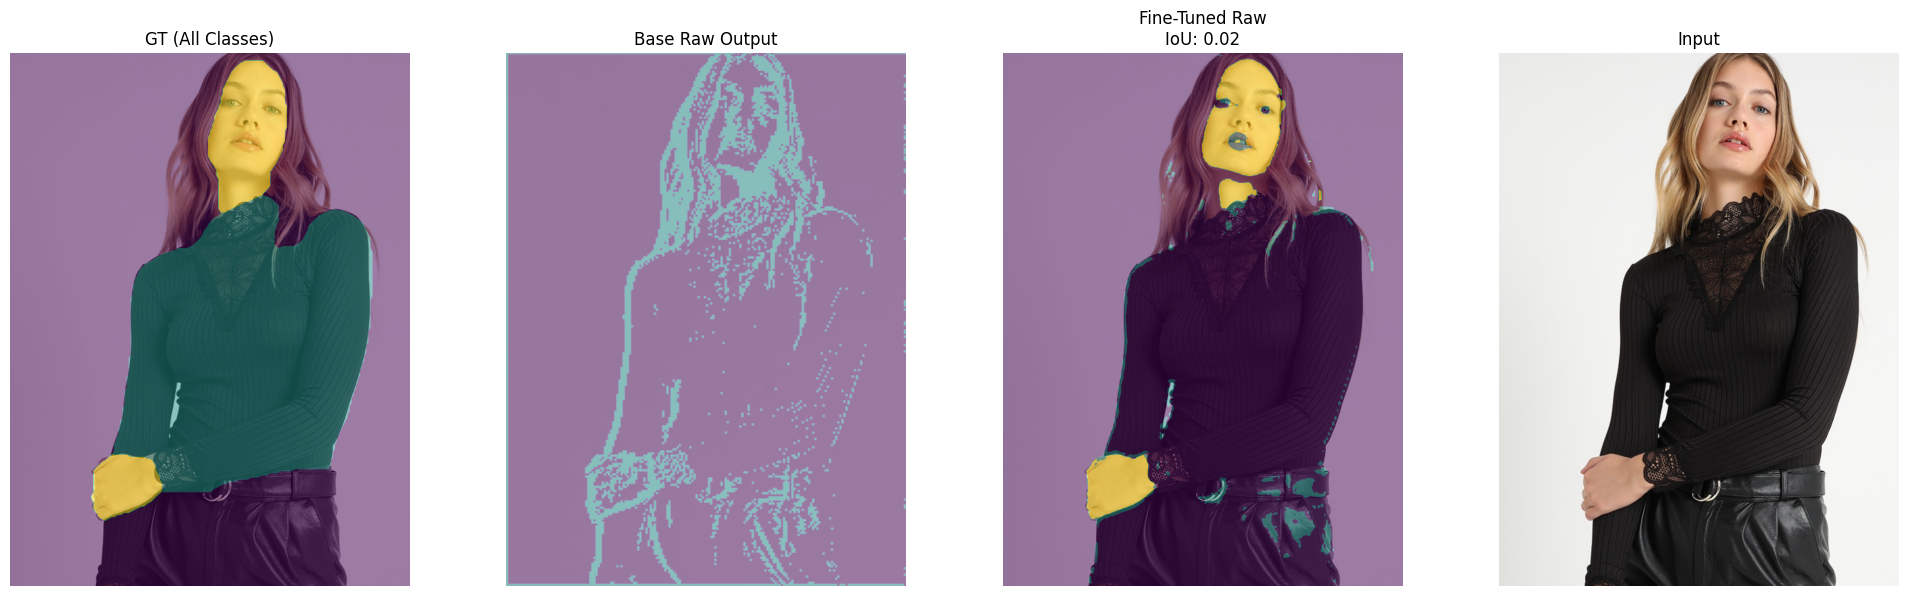

  1%|          | 3/508 [00:04<13:04,  1.55s/it]

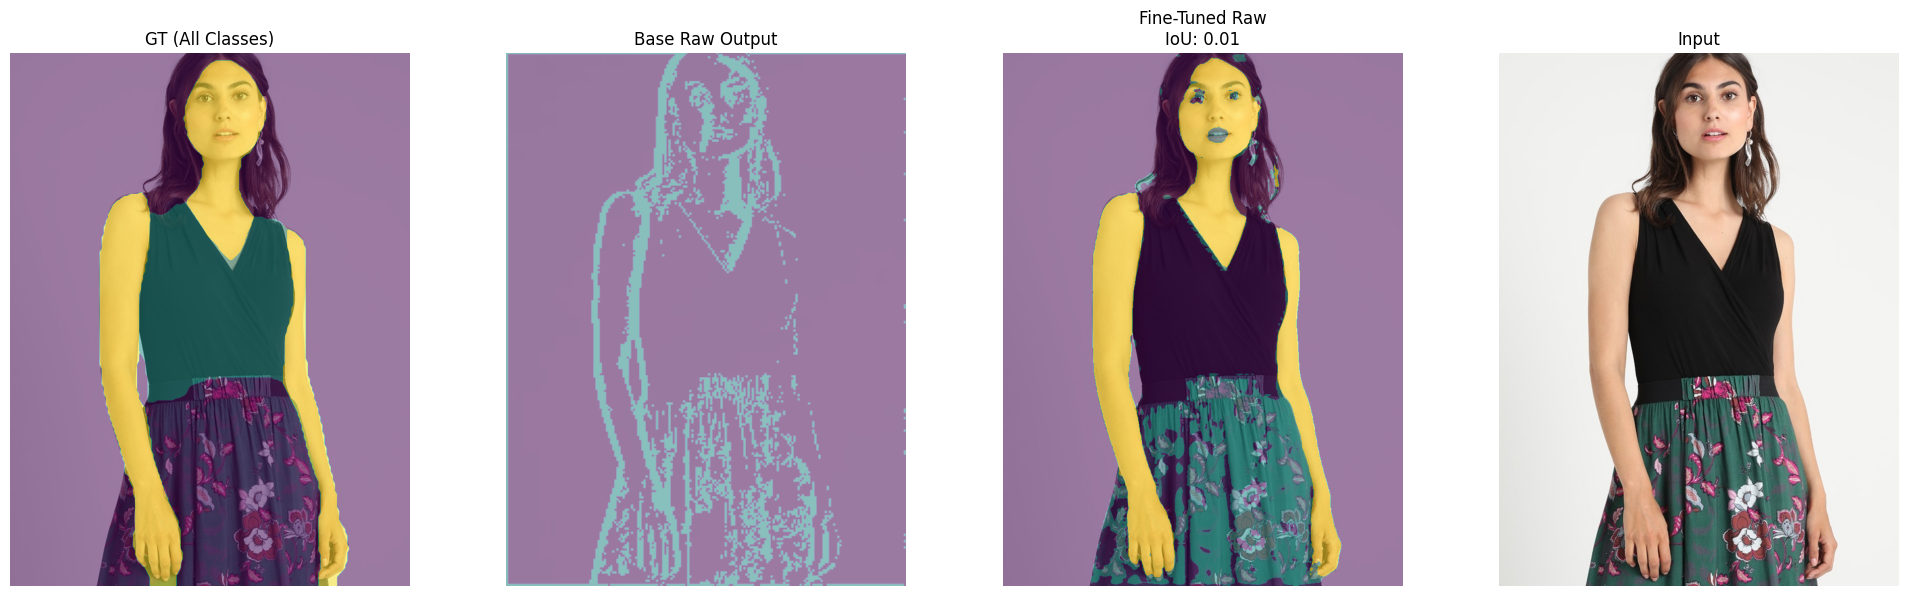

  1%|          | 4/508 [00:06<12:20,  1.47s/it]

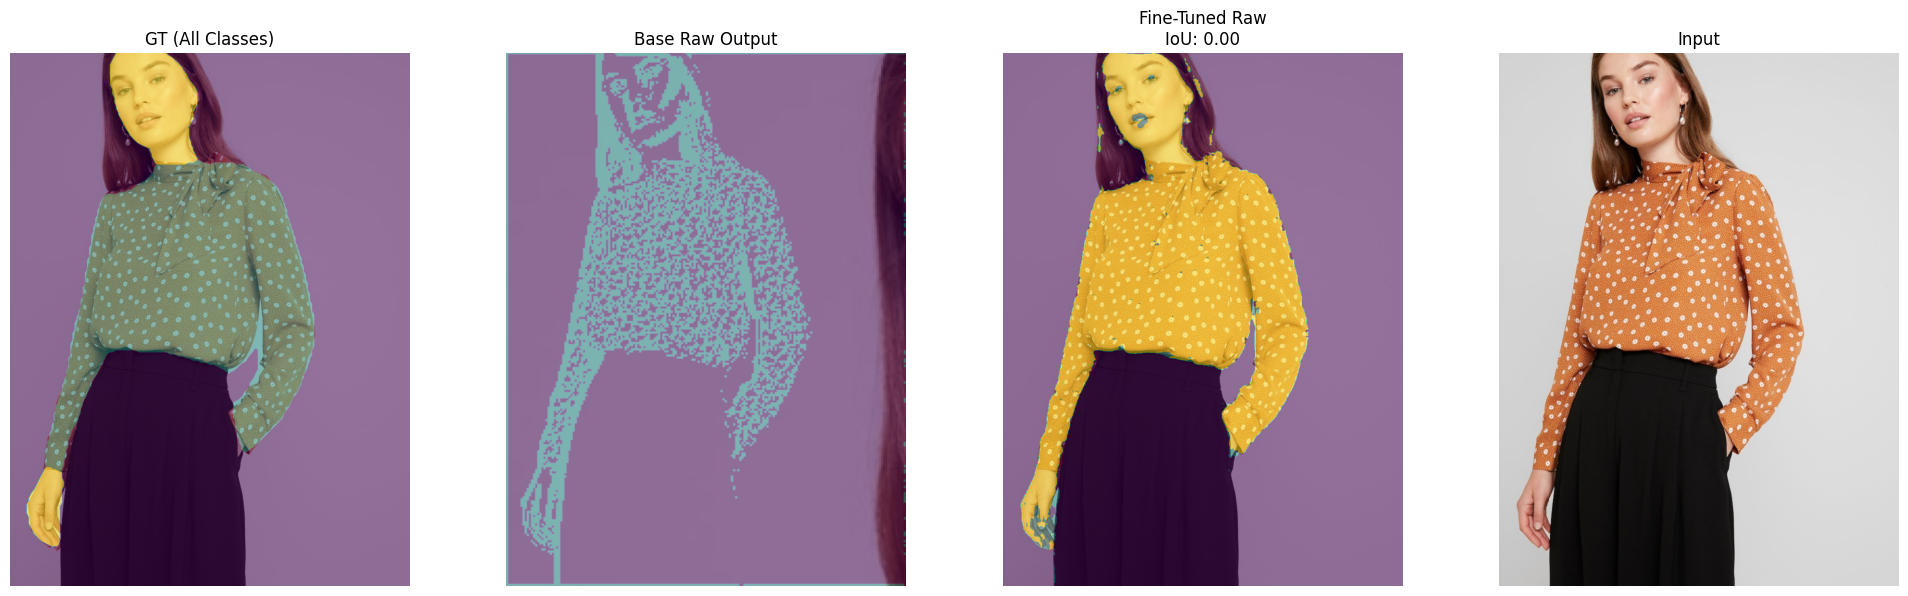

100%|██████████| 508/508 [03:50<00:00,  2.21it/s]


=== Final Results (Upper Clothes Class 1) ===
Base Model mIoU: 0.1516
Fine-Tuned mIoU: 0.2741


In [ ]:
def compute_iou(pred_mask, gt_mask, target_class=1):
    # Flatten
    pred = (pred_mask == target_class).astype(np.uint8).flatten()
    gt = (gt_mask == target_class).astype(np.uint8).flatten()
    
    intersection = np.logical_and(pred, gt).sum()
    union = np.logical_or(pred, gt).sum()
    
    if union == 0: return 0.0
    return intersection / union
    
metrics = {"Base": [], "FT": []}

vis_count = 0
MAX_VIS = 5

print("Starting Evaluation (Upper Clothes Only)...")

for batch in tqdm(dataloader):
    img_tensor = batch['tensor'].to(device)
    original_img = batch['original_img'][0].numpy()
    gt_mask = batch['gt_mask'][0].numpy() 
    
    # Get original image dimensions (H, W)
    target_h, target_w = gt_mask.shape
    
    # Skip if GT has no Upper Clothes (Class 1)
    if (gt_mask == 1).sum() == 0:
        continue

    # HRNet Base
    with torch.no_grad():
        out = hrnet_base(img_tensor)
        # Upsample Logits to Full Size
        out = F.interpolate(out, size=(target_h, target_w), mode='bilinear', align_corners=False)
        pred = torch.argmax(out, dim=1).cpu().numpy()[0]
        
        metrics["Base"].append(compute_iou(pred == 1, gt_mask == 1))

    # HRNet Fine-Tuned
    with torch.no_grad():
        out = hrnet_ft(img_tensor)
        # Upsample Logits to Full Size
        out = F.interpolate(out, size=(target_h, target_w), mode='bilinear', align_corners=False)
        pred = torch.argmax(out, dim=1).cpu().numpy()[0]
        
        metrics["FT"].append(compute_iou(pred == 1, gt_mask == 1))

    torch.cuda.empty_cache()

    if vis_count < MAX_VIS:
        fig, axs = plt.subplots(1, 4, figsize=(20, 6))
        
        axs[0].imshow(original_img)
        axs[0].imshow(gt_mask, cmap='viridis', alpha=0.5, vmin=0, vmax=2)
        axs[0].set_title("GT (All Classes)")
        axs[0].axis('off')

        axs[1].imshow(original_img)
        axs[1].imshow(torch.argmax(hrnet_base(img_tensor), 1)[0].cpu().numpy(), cmap='viridis', alpha=0.5, vmin=0, vmax=2)
        axs[1].set_title("Base Raw Output")
        axs[1].axis('off')

        axs[2].imshow(original_img)
        axs[2].imshow(pred, cmap='viridis', alpha=0.5, vmin=0, vmax=2)
        axs[2].set_title(f"Fine-Tuned Raw\nIoU: {metrics['FT'][-1]:.2f}")
        axs[2].axis('off')
        
        axs[3].imshow(original_img)
        axs[3].set_title("Input")
        axs[3].axis('off')

        plt.tight_layout()
        plt.show()
        vis_count += 1

print("\n=== Final Results (Upper Clothes Class 1) ===")
print(f"Base Model mIoU: {np.mean(metrics['Base']):.4f}")
print(f"Fine-Tuned mIoU: {np.mean(metrics['FT']):.4f}")